# Control Atlas and embedding

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sb
import anndata as ad
import scanpy as sc
import scipy
import path_config
from datetime import date
today = date.today()

import warnings
warnings.filterwarnings("ignore")
sb.set_context(context='poster')

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80)

# set a random seed
np.random.seed(0)


scanpy==1.9.8 anndata==0.9.2 umap==0.5.5 numpy==1.24.4 scipy==1.10.1 pandas==1.5.3 scikit-learn==1.1.3 statsmodels==0.14.1 igraph==0.10.8 louvain==0.8.1 pynndescent==0.5.11


In [2]:
output_path = path_config.output_path
input_path = output_path

In [3]:
condition = 'control'
HIGHLY_VARIABLE_GENES = 10000

Read adata files

In [4]:
adata = sc.read(output_path + '/campari_scs_umap_cells_'+condition + '_'+str(HIGHLY_VARIABLE_GENES)+'_excluded.h5ad')
adata_all = sc.read(output_path + '/campari_scs_umap_all_cells_'+condition + '_'+str(HIGHLY_VARIABLE_GENES)+'_excluded.h5ad')
adata_all_norm = sc.read(output_path + '/campari_scs_umap_all_norm_cells_'+condition + '_'+str(HIGHLY_VARIABLE_GENES)+'_excluded.h5ad')


In [5]:
# rescale
sc.pp.regress_out(adata, ['total_counts','pct_counts_mt'])
sc.pp.scale(adata,max_value=10)

regressing out ['total_counts', 'pct_counts_mt']
    finished (0:01:24)


## Split to control and campari cells

In [6]:
print(adata.shape)
x = adata.X
stim = np.zeros((x.shape[0],))
for i in range(x.shape[0]):
    stim[i] = adata.obs['stimulus'][i]
    
## We split the cels between campari and control cells
campari_cells = np.logical_and(stim != 0,stim!=0)
control_cells = np.logical_or(stim == 0, stim==0)
campari_cells = np.where(campari_cells)[0]
control_cells = np.where(control_cells)[0]
print('Number of campari cells = ', len(campari_cells))
print('Number of control cells = ', len(control_cells))

(3754, 9993)
Number of campari cells =  2851
Number of control cells =  903


In [7]:
adata_campari = adata[campari_cells,:]
adata_control = adata[control_cells,:]

adata_all_control = adata_all[control_cells,:]
adata_all_campari = adata_all[campari_cells,:]

adata_all_norm_control = adata_all_norm[control_cells,:]
adata_all_norm_campari = adata_all_norm[campari_cells,:]

Remove unused stimulus from campari dataset.<br>We don't want to embedd it in the atlas.

In [8]:
print("Cells before filtering:", adata_campari.n_obs)
adata_campari = adata_campari[adata_campari.obs['stimulus'] != -1].copy()
print("Cells after filtering:", adata_campari.n_obs)

Cells before filtering: 2851
Cells after filtering: 931


## Dimentionality Reduction on Atlas

computing PCA
    on highly variable genes
    with n_comps=25
    finished (0:00:01)


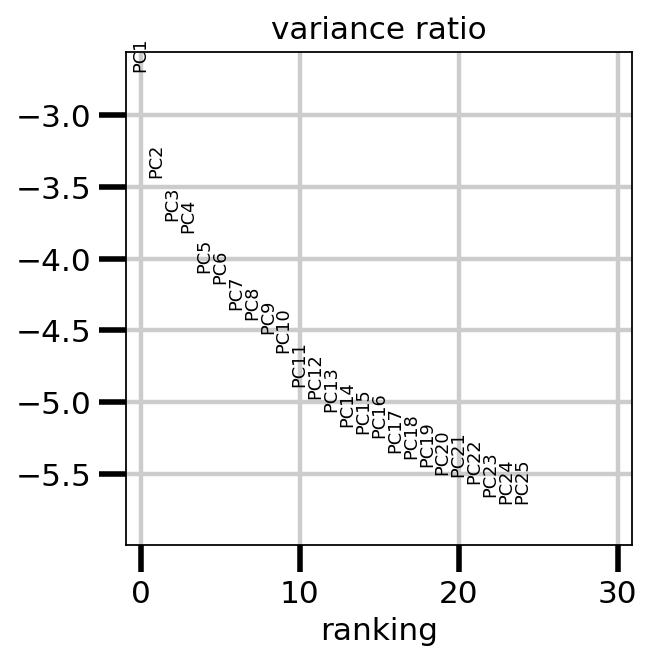

Cumulative variance explained by the first 25 components: 29.60%


In [9]:
### Dimentionality reduction examples using multiple techniques
### Select one number of componets, for example n = 15 and do louvain in the umap transformation 
### with that number of componets
N_selected = 25

sc.tl.pca(adata_control, use_highly_variable=True, svd_solver='arpack',n_comps=N_selected)
sc.pl.pca_variance_ratio(adata_control, log=True)

# Access the explained variance
explained_variance = adata_control.uns['pca']['variance_ratio'][:N_selected]  # This gives the variance explained by the first N components

# Print the cumulative variance explained by the first N components
cumulative_variance = explained_variance.cumsum()[-1]
print(f"Cumulative variance explained by the first {N_selected} components: {cumulative_variance:.2%}")
 

In [10]:
# dim reduction
sc.pp.neighbors(adata_control)
sc.tl.tsne(adata_control)
sc.tl.umap(adata_control)

computing neighbors
    using 'X_pca' with n_pcs = 25
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing tSNE
    using 'X_pca' with n_pcs = 25
    using sklearn.manifold.TSNE
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


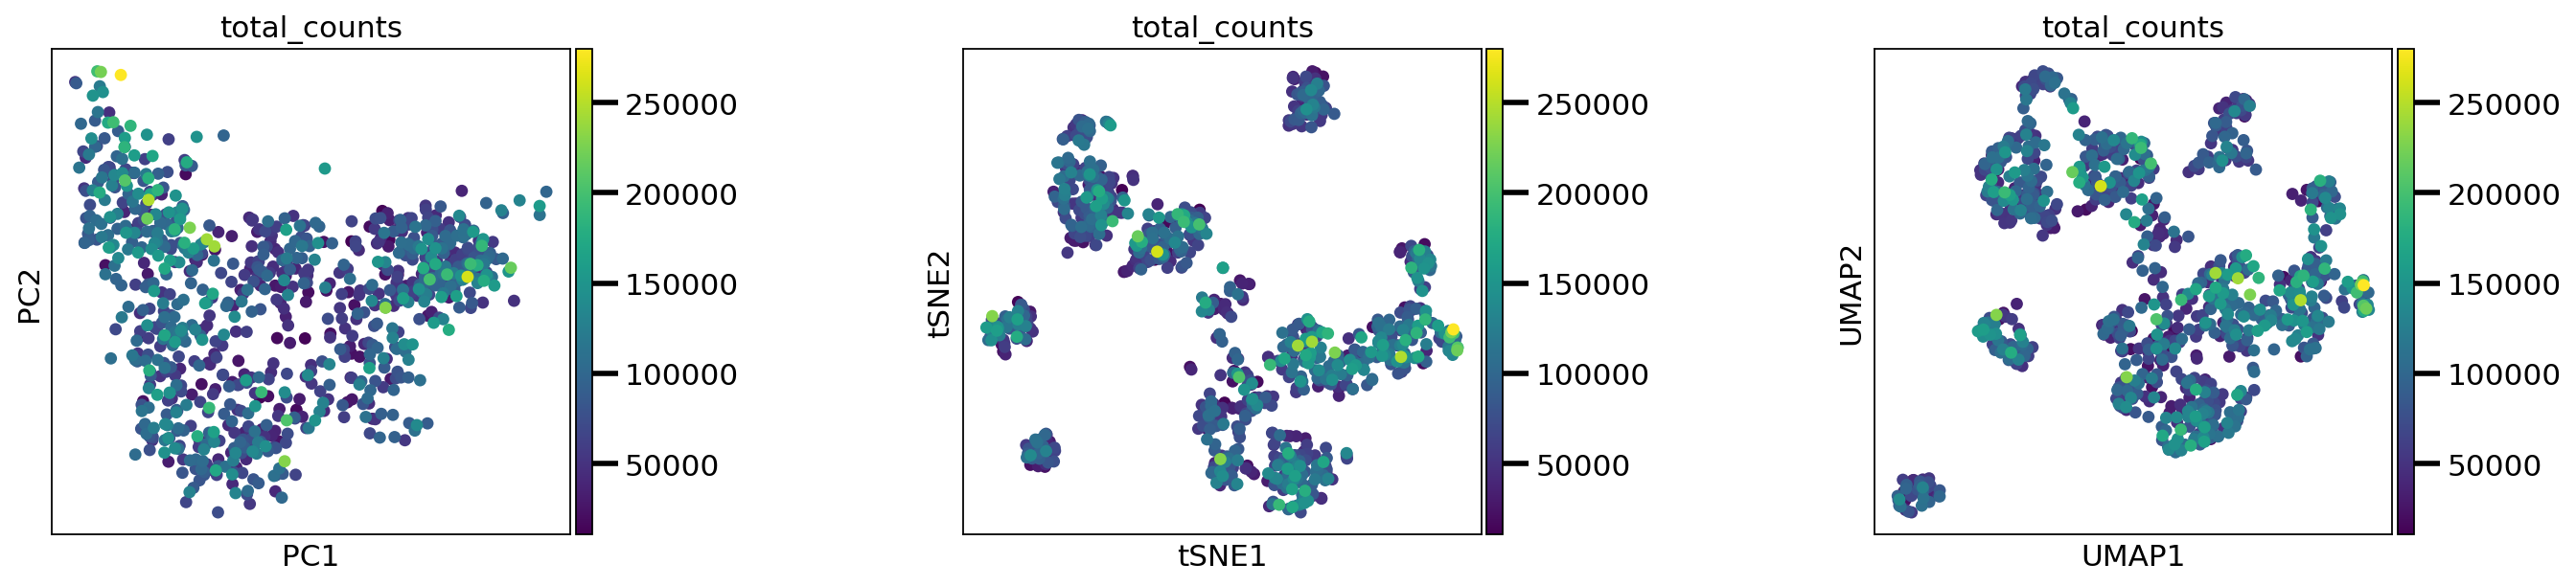

In [11]:
rcParams['figure.figsize']=(20,10)
fig_ind=np.arange(231, 237)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6)
 
p10 = sc.pl.pca_scatter(adata_control, color='total_counts', ax=fig.add_subplot(fig_ind[0]), show=False)
p11 = sc.pl.tsne(adata_control, color='total_counts', ax=fig.add_subplot(fig_ind[1]), show=False)
p12 = sc.pl.umap(adata_control, color='total_counts', ax=fig.add_subplot(fig_ind[2]), show=False)

In [12]:
# Perform clustering - using highly variable genes
louvain_paramenters = [2.5,3,3.5]
louvain_names = []
for value in louvain_paramenters:
    louvain_names.append('louvain_r' + str(value))

for value,name in zip(louvain_paramenters,louvain_names):
    sc.tl.louvain(adata_control, resolution=value, key_added=name) 

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 17 clusters and added
    'louvain_r2.5', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 19 clusters and added
    'louvain_r3', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 21 clusters and added
    'louvain_r3.5', the cluster labels (adata.obs, categorical) (0:00:00)


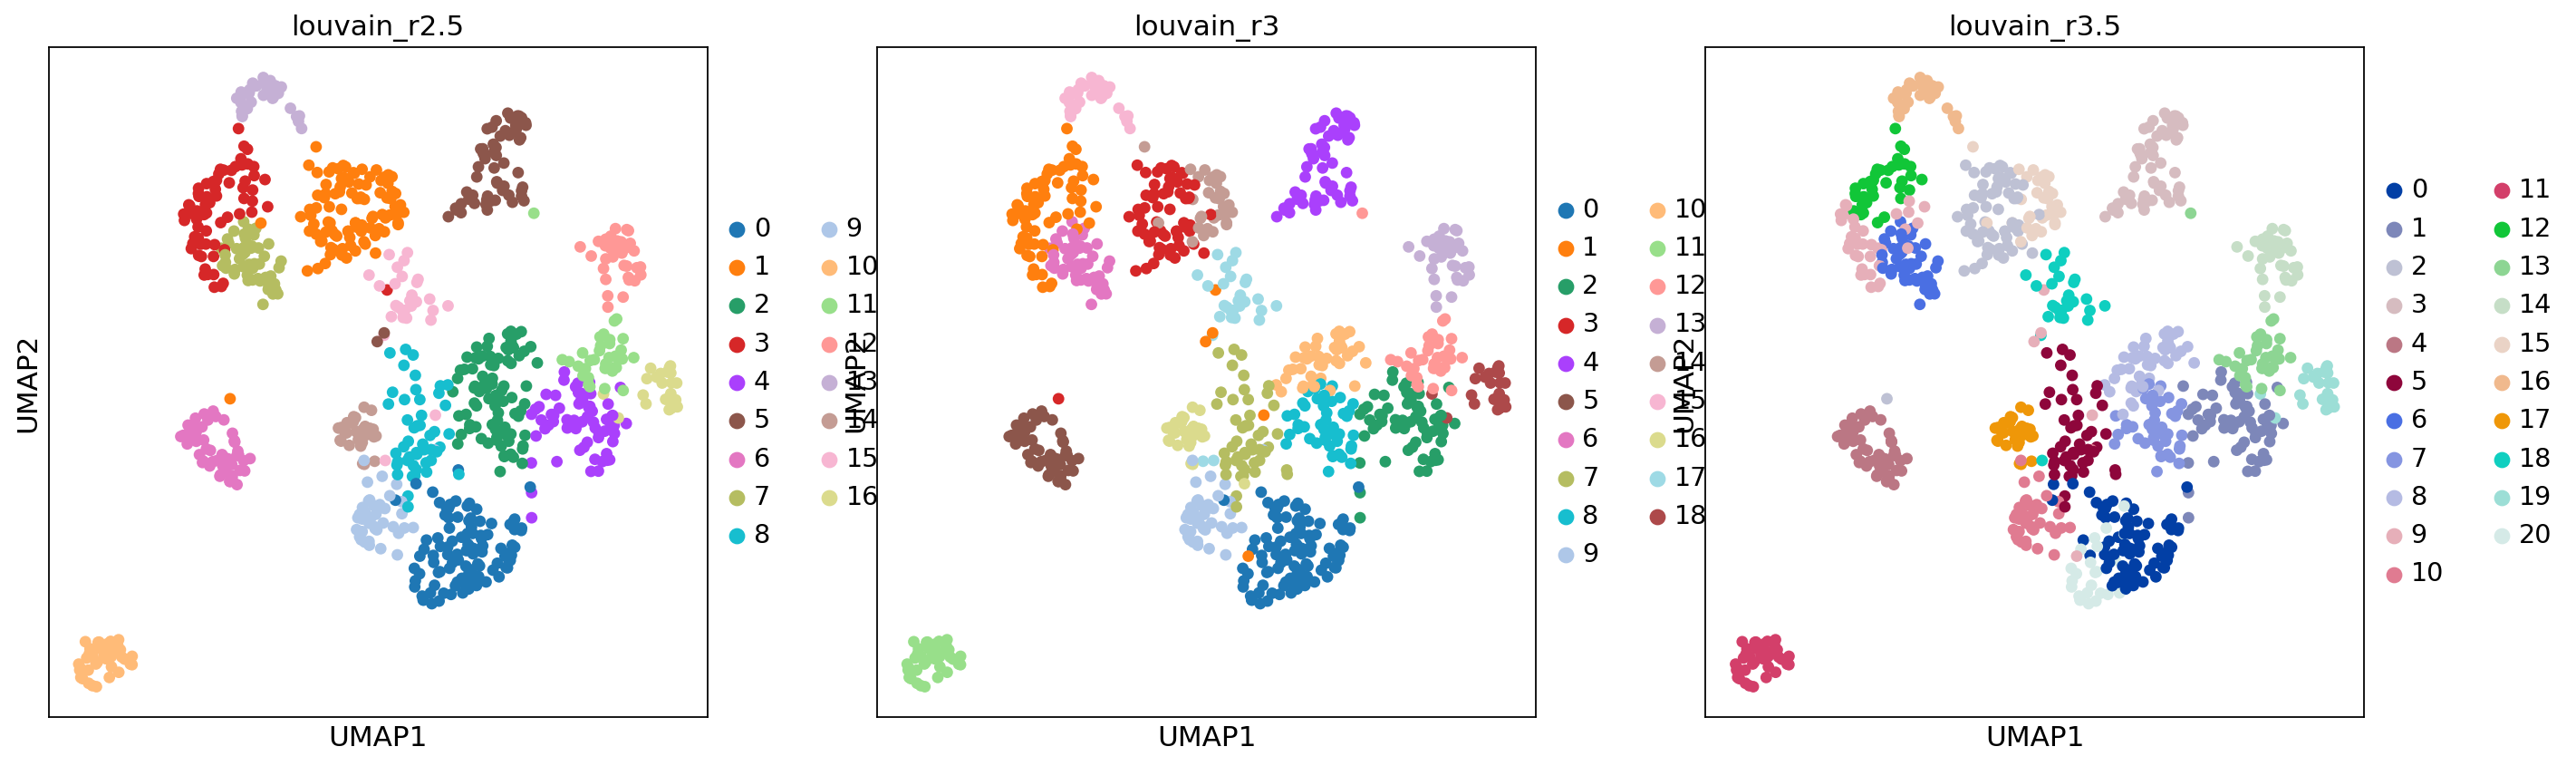

In [13]:
rcParams['figure.figsize']=(6,6)
#Visualize the clustering and how this is reflected by different technical covariates
#for name in louvain_names:
sc.pl.umap(adata_control, color=louvain_names)

For each clustering, embedd campari in control atlas

In [14]:
louvain_names = []
for value in louvain_paramenters:
    louvain_names.append('louvain_r' + str(value))

for clustering_method in louvain_names:
    sc.tl.ingest(adata_campari, adata_control, obs=clustering_method, embedding_method='umap')
    adata_campari.obs['transfered_clusters_'+clustering_method] = adata_campari.obs[clustering_method]
    adata_control.obs['clusters_'+clustering_method] = adata_control.obs[clustering_method]
    
    adata_concat = adata_control.concatenate(adata_campari, batch_categories=["control", "campari"])
    adata_all_concat = adata_all_control.concatenate(adata_all_campari, batch_categories=["control", "campari"])
    adata_all_norm_concat = adata_all_norm_control.concatenate(adata_all_norm_campari, batch_categories=["control", "campari"])

running ingest
    finished (0:00:18)
running ingest
    finished (0:00:02)
running ingest
    finished (0:00:02)


## Choose clustering method for the Atlas

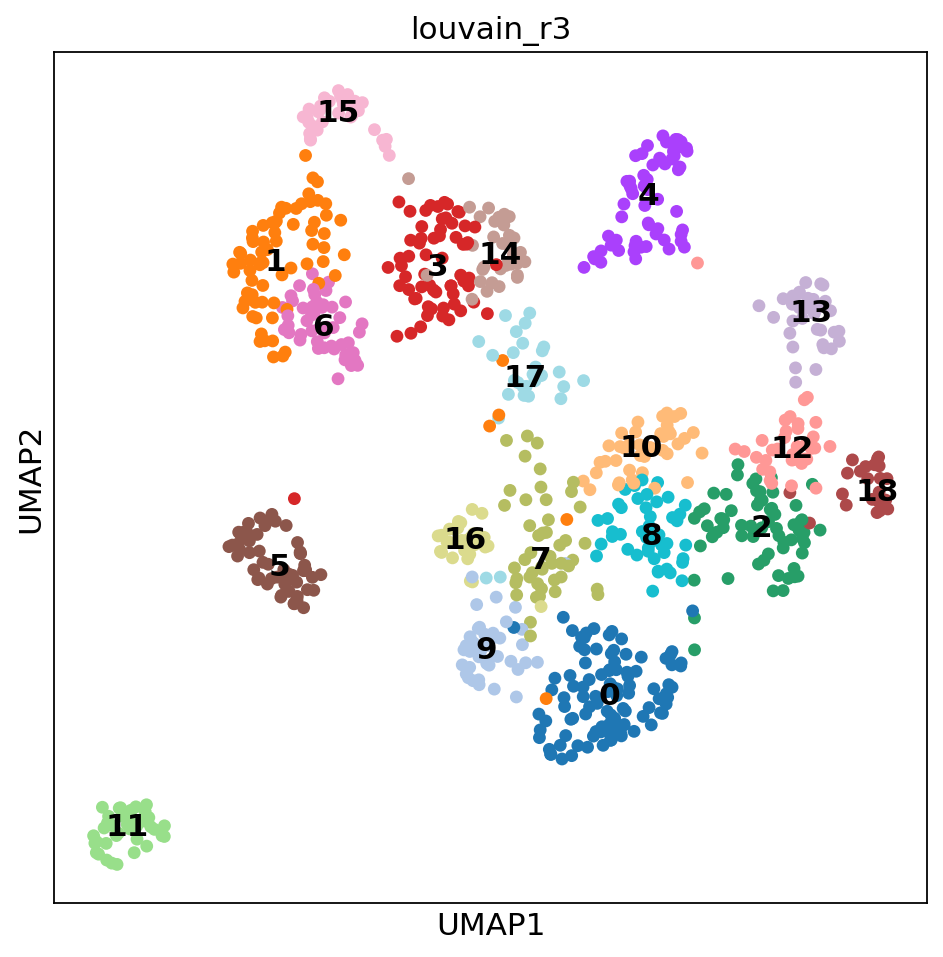

In [15]:
clustering_method = 'louvain_r3'
rcParams['figure.figsize']=(7,7)

sc.pl.umap(adata_control, color=clustering_method, legend_loc='on data')

Explore marker genes on atlas

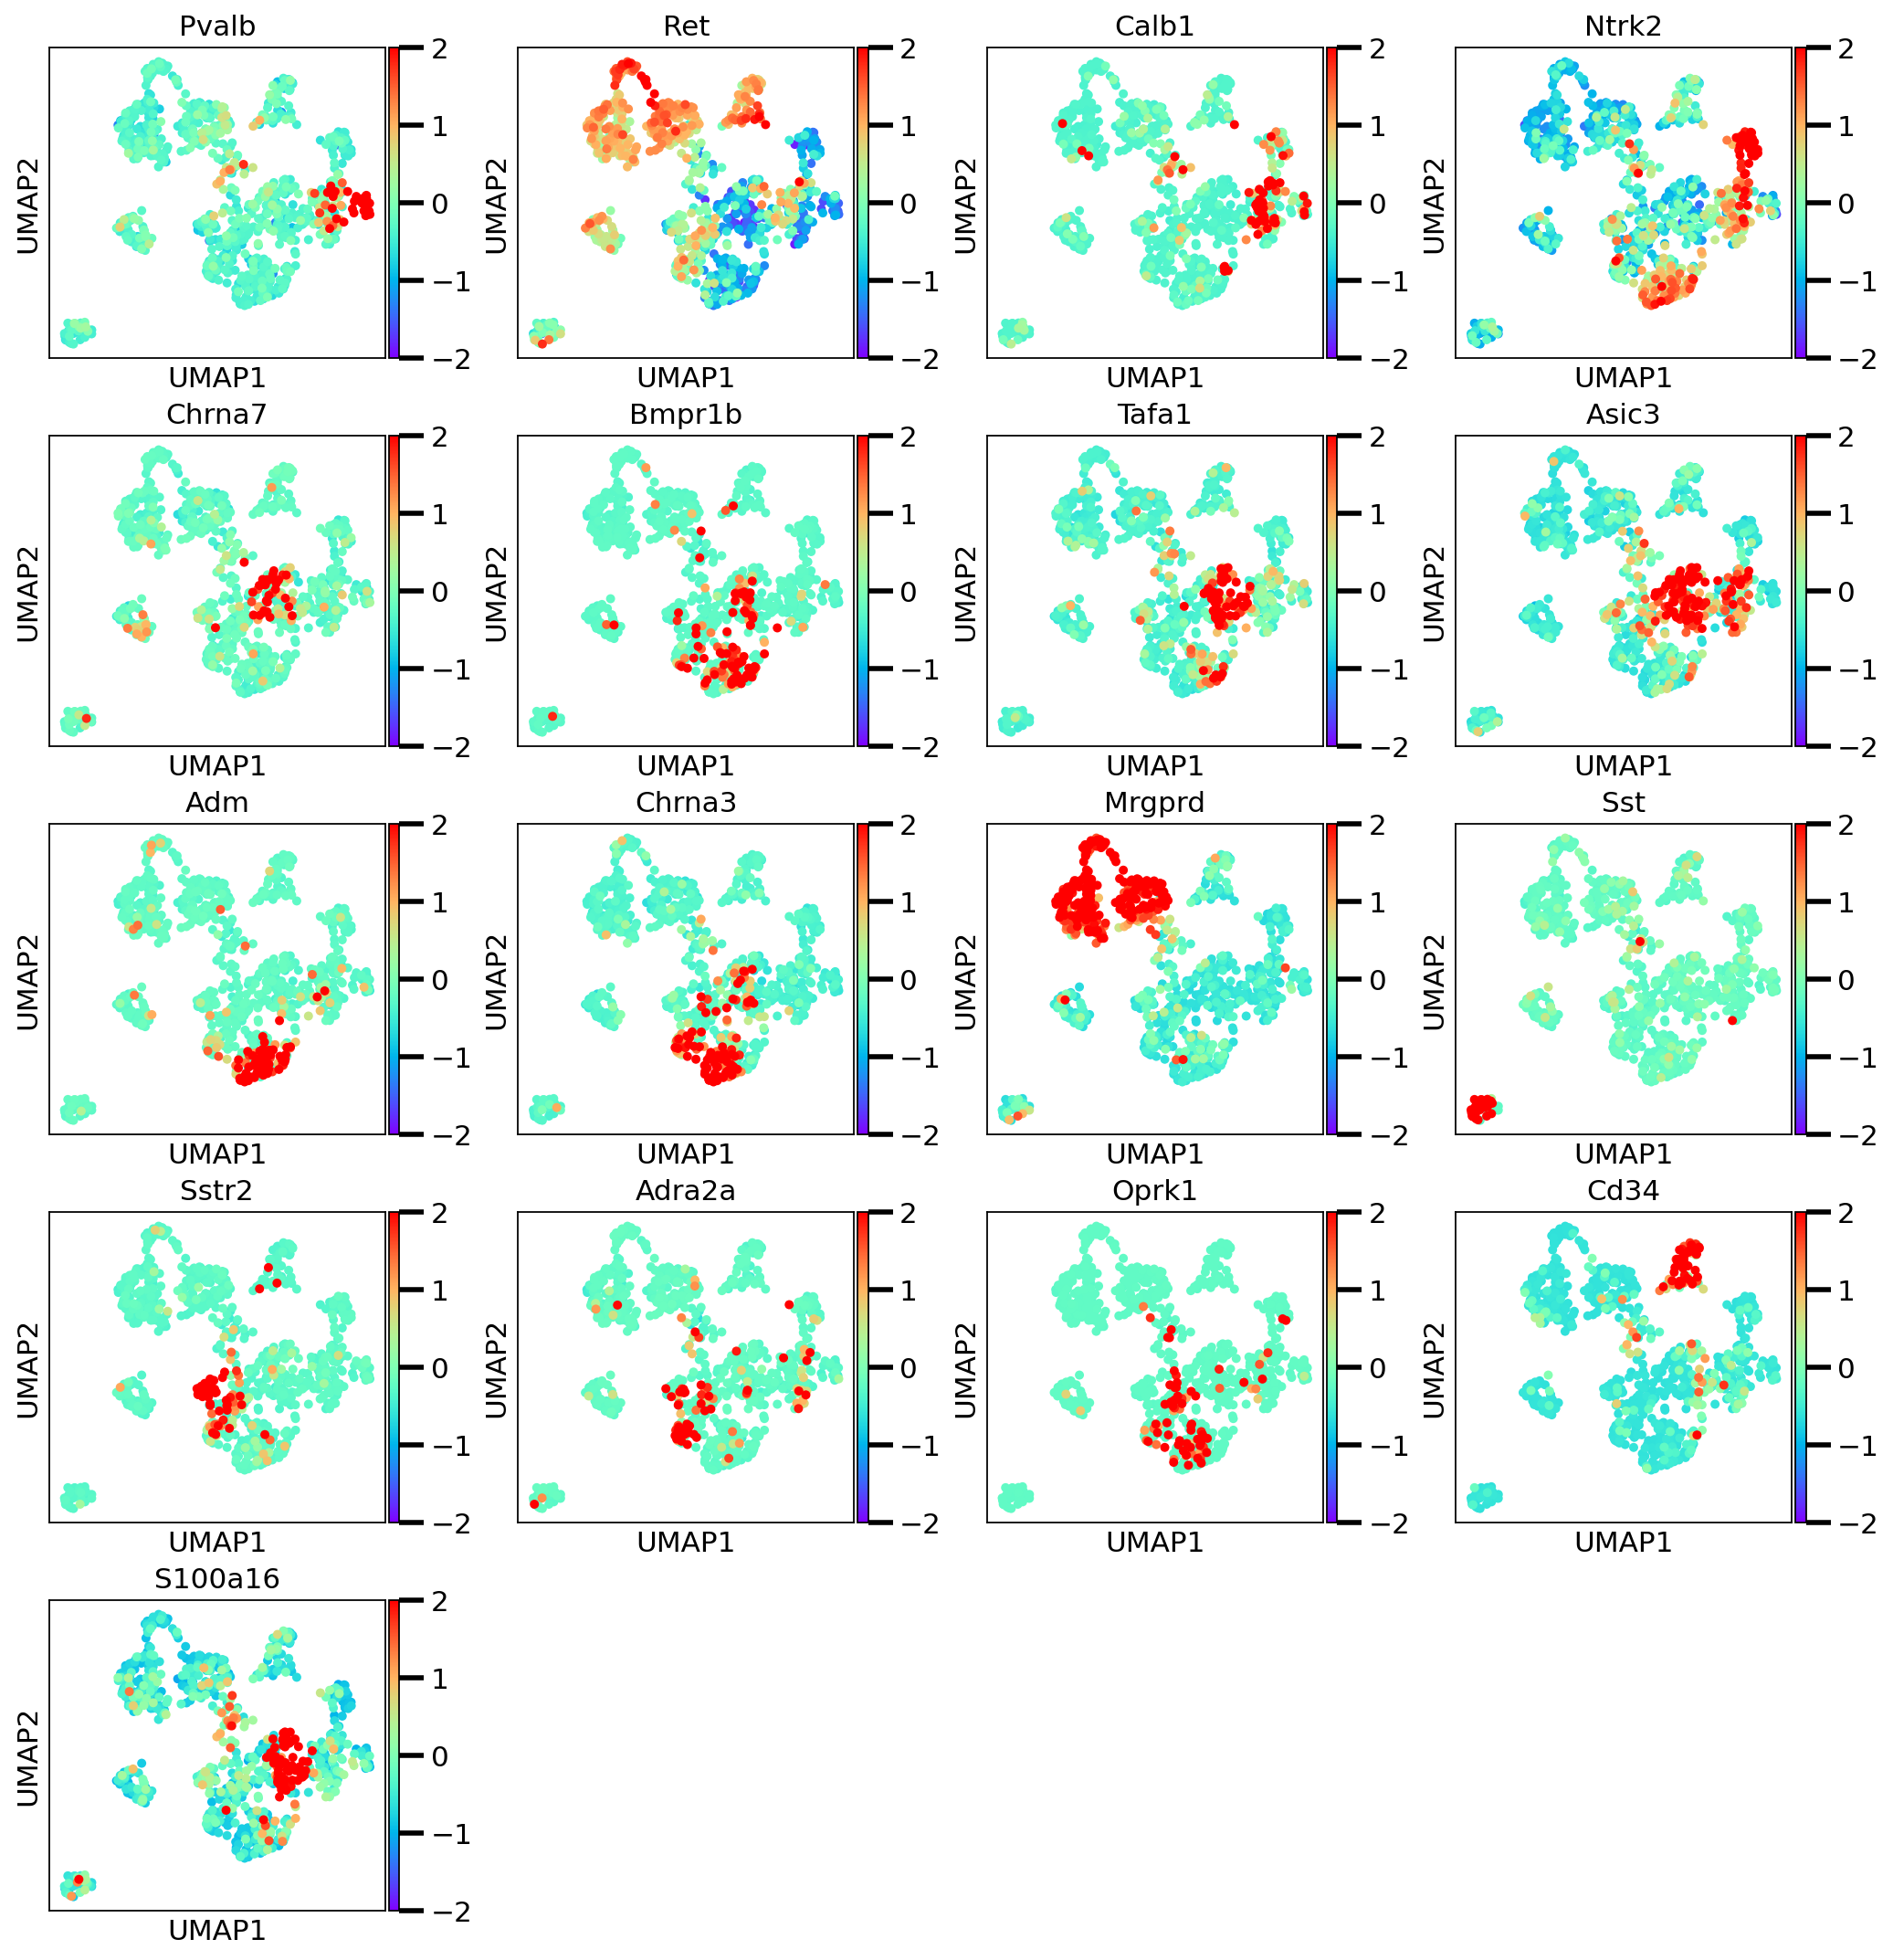

In [16]:
rcParams['figure.figsize']=(3,3)

marker_genes = ['Pvalb','Ret','Calb1','Ntrk2','Chrna7','Bmpr1b','Tafa1','Asic3','Adm','Chrna3','Mrgprd','Sst','Sstr2','Adra2a','Oprk1','Cd34','S100a16']
sc.pl.umap(adata=adata_control, color=marker_genes, use_raw=False, cmap = 'rainbow',
           size = 80,vmin=-2, vmax=2)

## Merge some clusters in Atlas

In [17]:
# Define the clusters you want to merge and the new label for them
adata_control.obs['merged_'+clustering_method] = adata_control.obs[clustering_method]  # Copy the original clustering for safety
# Optional: Renumbering clusters after merging 
# merge Mrgprd to a single cluster, calb1+S100b to one 
new_clusters = {
    '0': '0',  
    '1': '1',  
    '2': '2',  
    '3': '1',  
    '5': '5',
    '6': '1',
    '7': '7',
    '8': '8',
    '9': '9',
    '10': '10',
    '11': '11',
    '12': '2',
    '13': '13',
    '14': '1',
    '15': '1',
    '16': '16',
    '17': '17',
    '18': '18'
}


adata_control.obs['merged_'+clustering_method] = adata_control.obs['merged_'+clustering_method].replace(new_clusters)

cluster_names =  {
    0: "PEP4 (Bmpr1b-Adm)",
    1: "NP1 (Mrgprd)",
    2: "Abeta (Calb1-Grm8)",
    4: "C-LTMR (Th)",
    5: "NP2 (Mrgpra3-Mrgprb4)",
    7: "PEP1.4 (Oprk1)",
    8: "PEP3 (Bmpr1b-Krt79)",
    9:  "PEP1.3 (Adra2a)",
    10: "PEP2 (Smr2-Chrna7)",
    11: "NP3-(Sst)",
    13: "Adelta (Ntrk2 high)",
    16: "PEP1.1 (Sstr2)",
    17: "UN",
    18: "Propioceptors (Pvalb)"
}

# Step 1: Copy the original clustering for safety
adata_control.obs['merged_'+clustering_method] = adata_control.obs[clustering_method]

# Step 2: Update cluster labels based on new_clusters dictionary
# Ensure the clusters are strings if your keys in new_clusters are strings
adata_control.obs['merged_'+clustering_method] = adata_control.obs['merged_'+clustering_method].astype(str)
adata_control.obs['merged_'+clustering_method] = adata_control.obs['merged_'+clustering_method].replace(new_clusters)

# Step 3: Map the cluster IDs to their names using the cluster_names dictionary
# Ensure that the merged clusters are integers before mapping to the names
adata_control.obs['named_'+clustering_method] = adata_control.obs['merged_'+clustering_method].astype(int)
adata_control.obs['named_'+clustering_method] = adata_control.obs['named_'+clustering_method].map(cluster_names)


# Show our cluster names on the plot

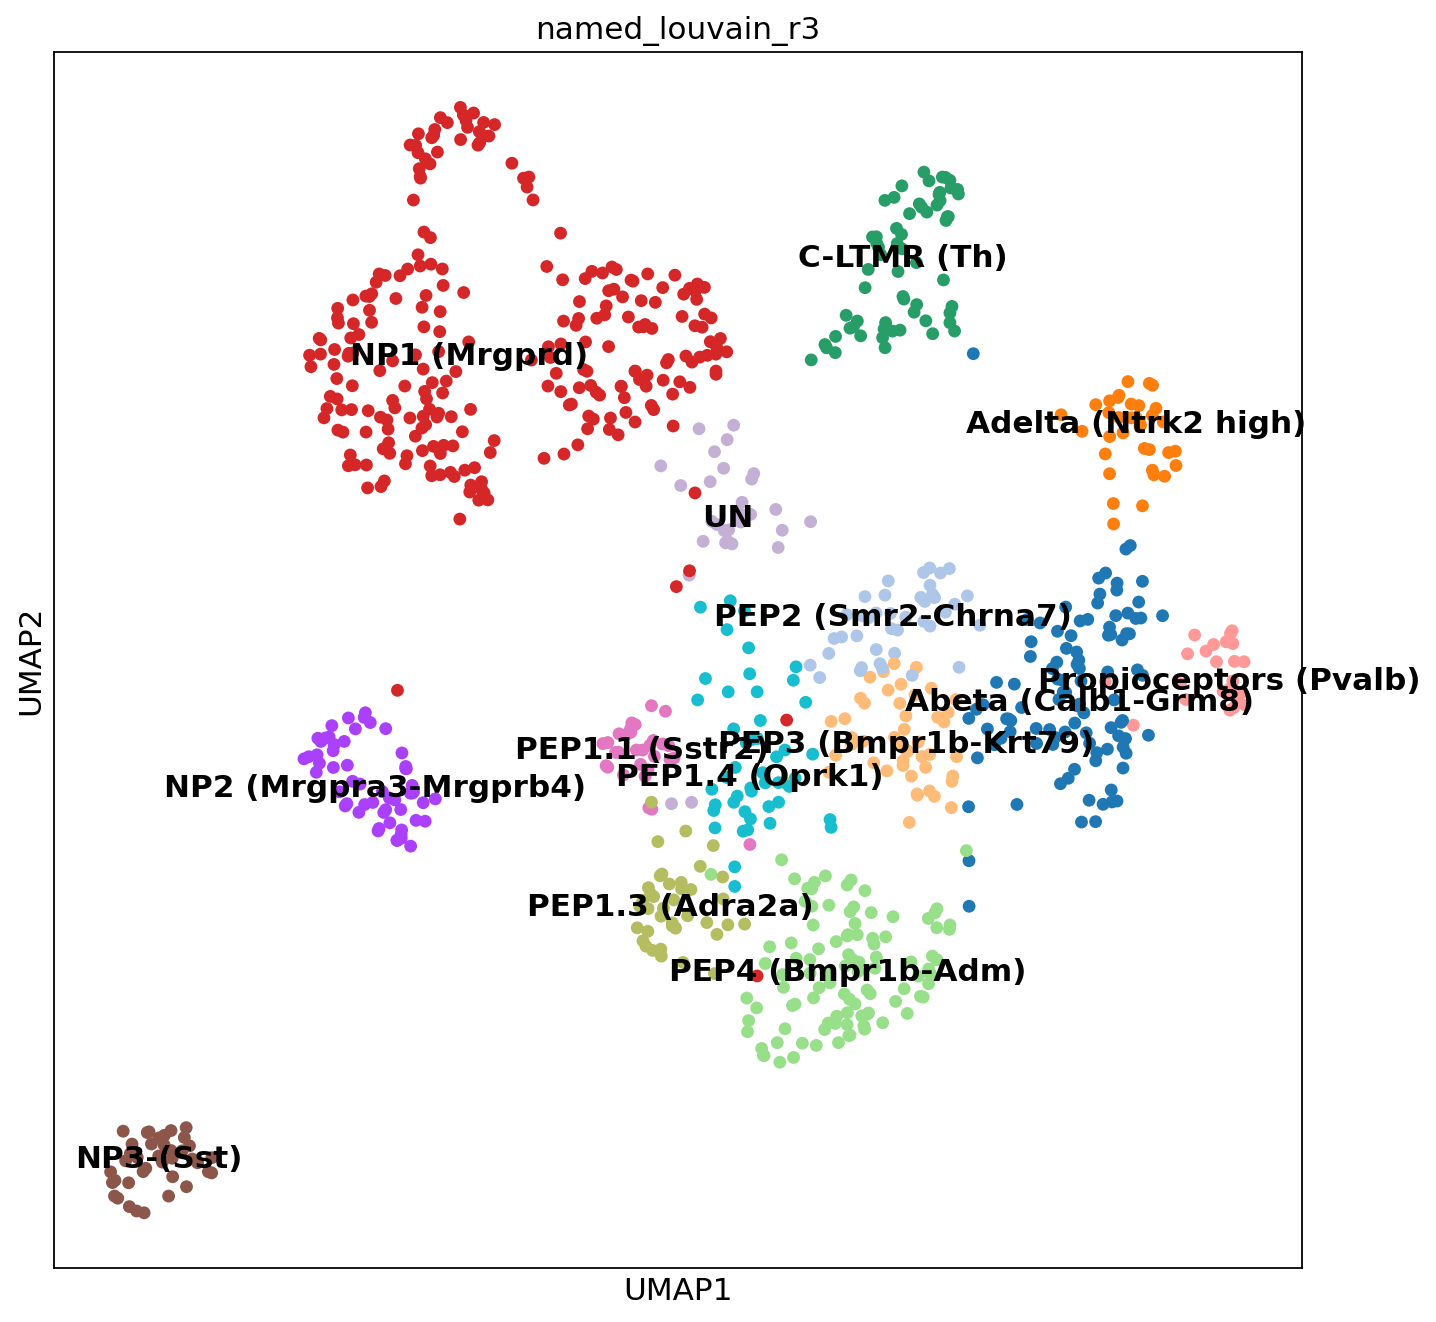

In [18]:
rcParams['figure.figsize']=(10,10)

sc.pl.umap(adata_control, color='named_' + clustering_method , legend_loc='on data')

## Embedd campari in Atlas

In [19]:
# so the campari has correct assignment for clusters (merged)
sc.tl.ingest(adata_campari, adata_control, obs='merged_' + clustering_method, embedding_method='umap')

running ingest
    finished (0:00:02)


Show embedded cells only

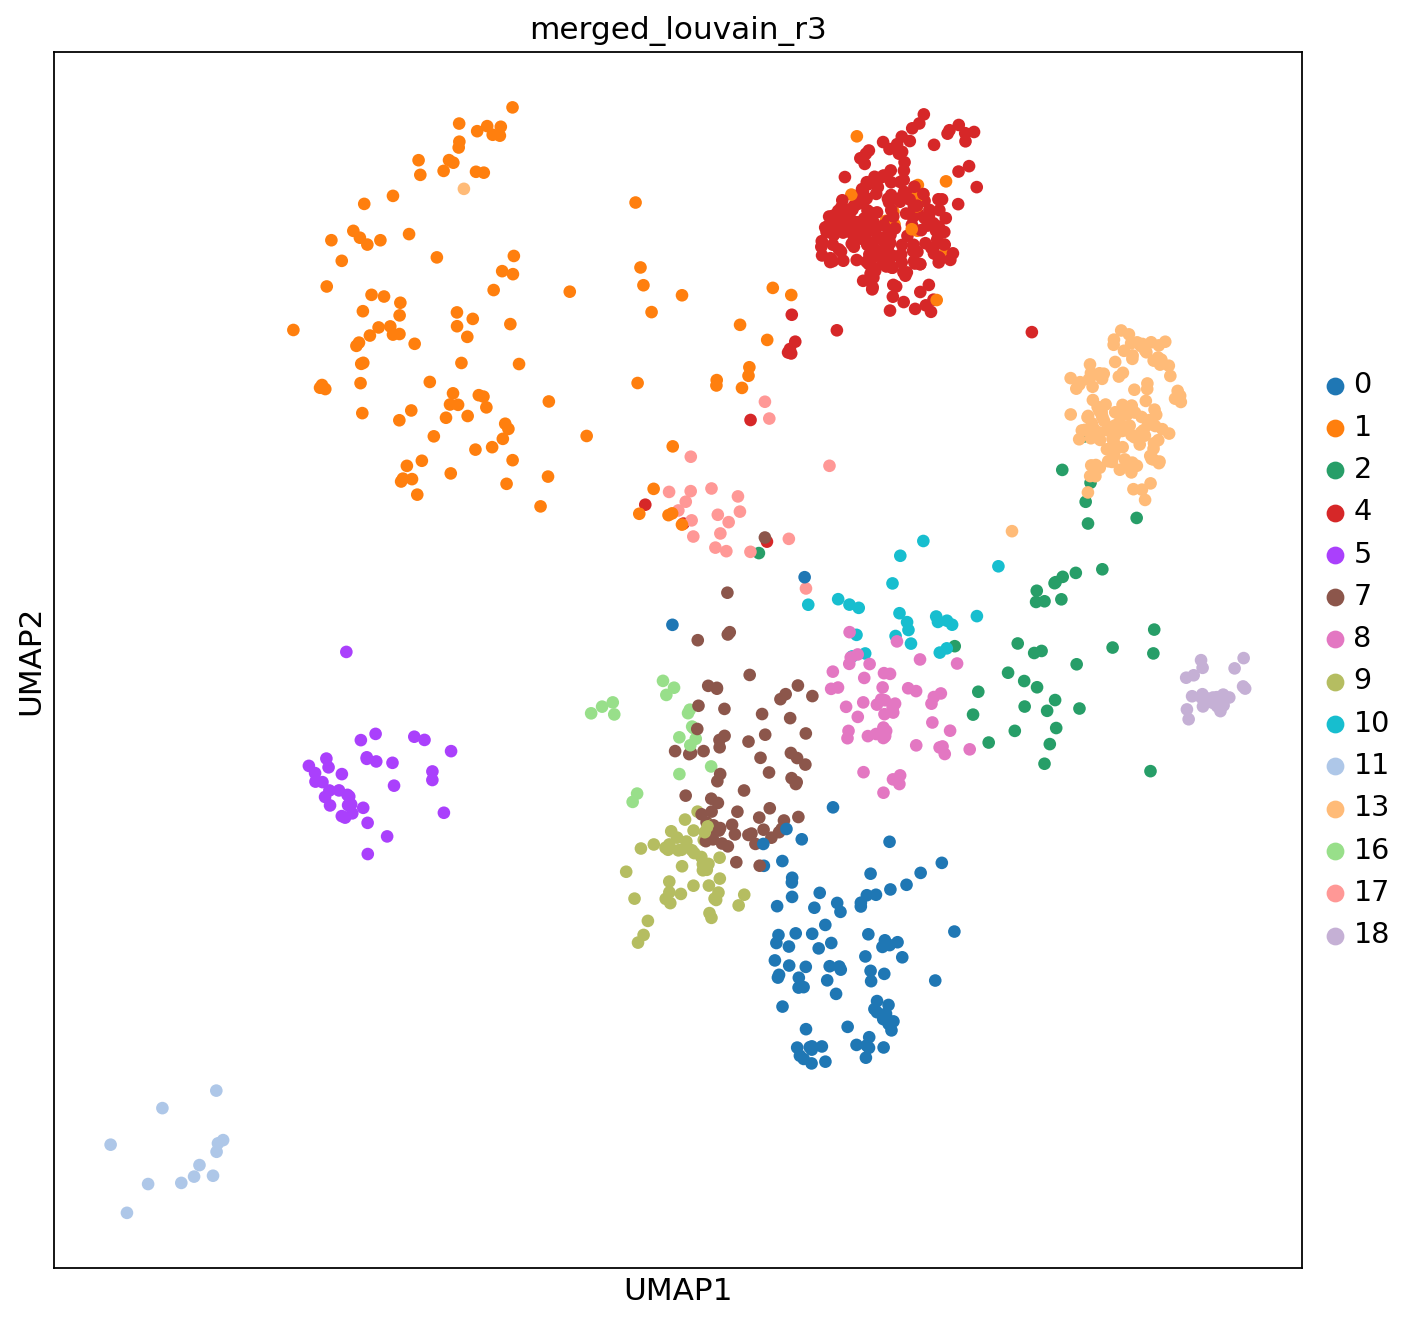

In [20]:
sc.pl.umap(adata_campari, color=['merged_' + clustering_method], wspace=0.3)
adata_campari.obs['transfered_clusters'] = adata_campari.obs['merged_'+clustering_method]
adata_control.obs['clusters'] = adata_control.obs['merged_'+clustering_method]
adata_campari.obs['named_' +clustering_method] = adata_campari.obs['merged_'+clustering_method]

# Ensure the clusters are strings if your keys in new_clusters are strings
adata_campari.obs['merged_'+clustering_method] = adata_campari.obs['merged_'+clustering_method].astype(str)
adata_campari.obs['merged_'+clustering_method] = adata_campari.obs['merged_'+clustering_method].replace(new_clusters)

# Step 3: Map the cluster IDs to their names using the cluster_names dictionary
# Ensure that the merged clusters are integers before mapping to the names
adata_campari.obs['named_'+clustering_method] = adata_campari.obs['merged_'+clustering_method].astype(int)
adata_campari.obs['named_'+clustering_method] = adata_campari.obs['named_'+clustering_method].map(cluster_names)


# Show all data together

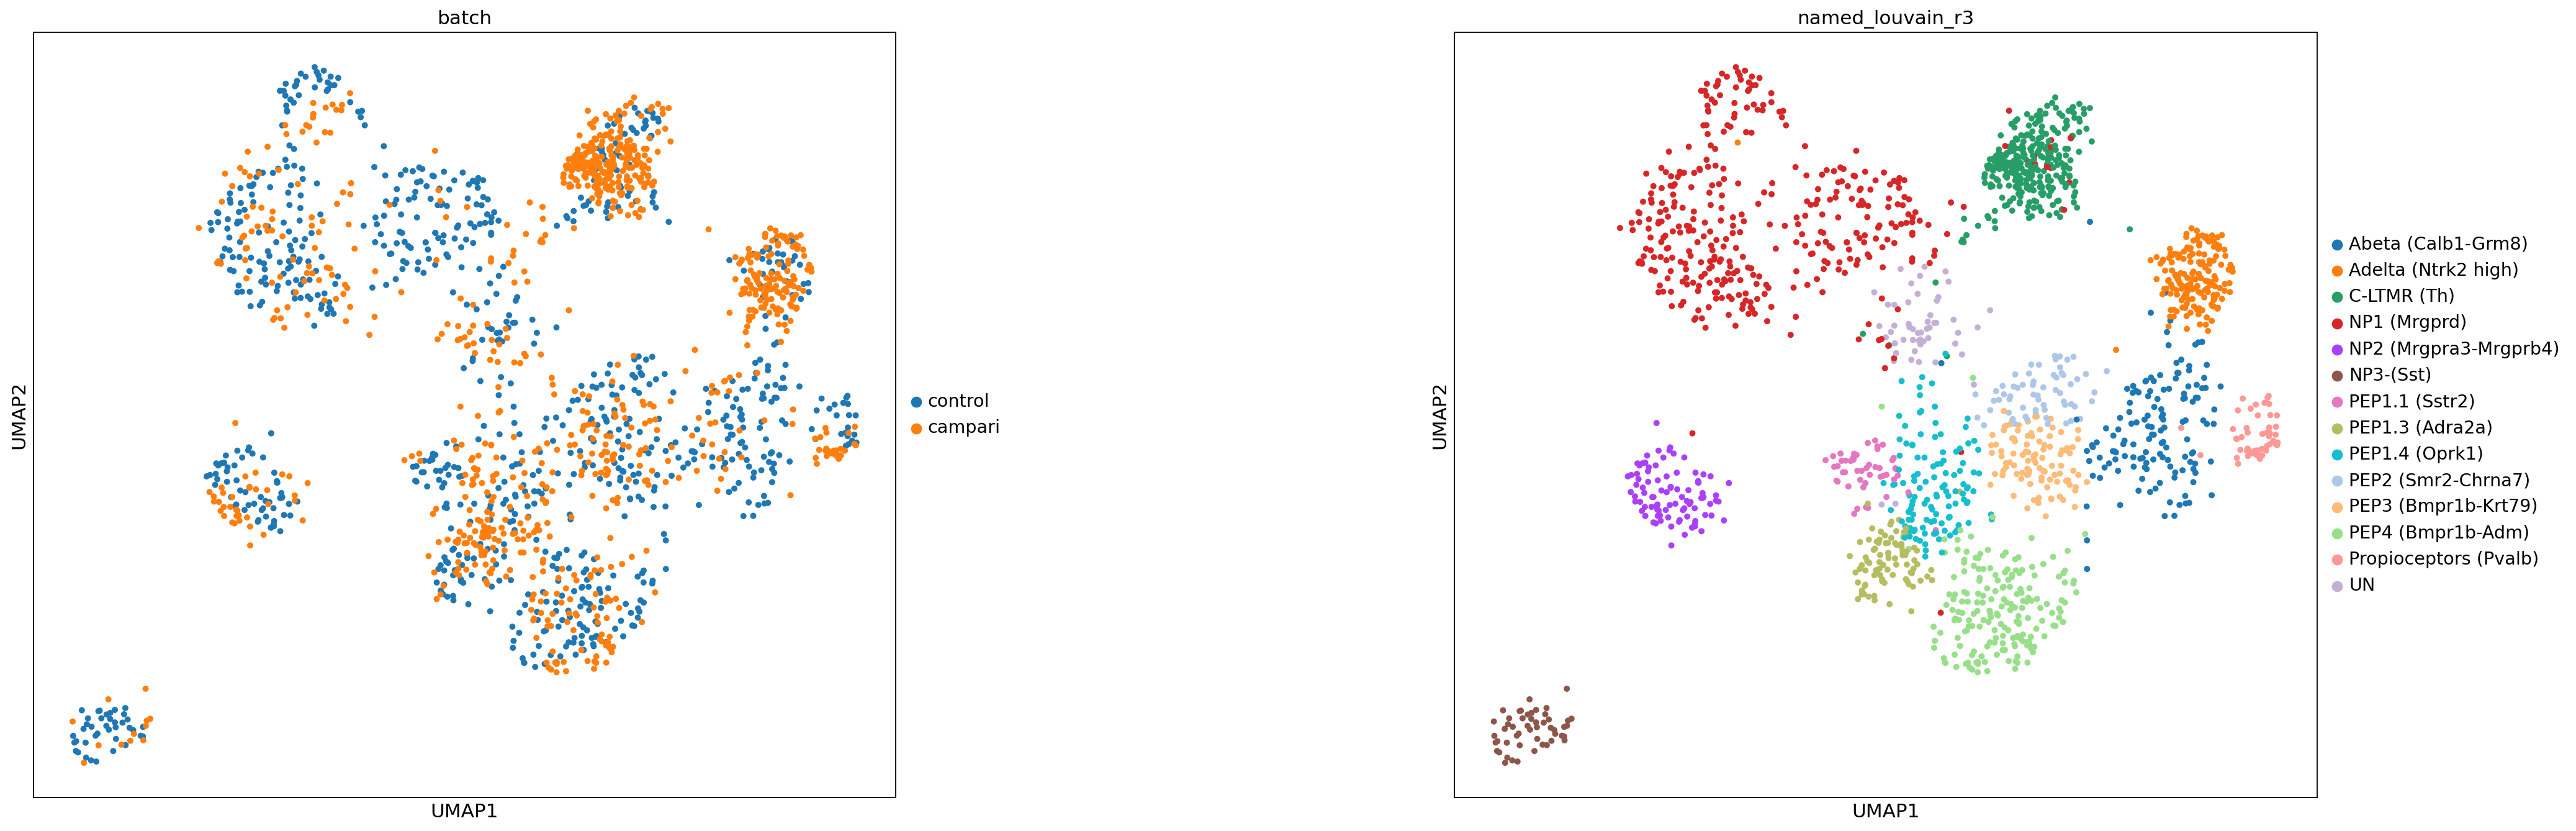

In [21]:
adata_concat = adata_control.concatenate(adata_campari, batch_categories=["control", "campari"])
adata_all_concat = adata_all_control.concatenate(adata_all_campari, batch_categories=["control", "campari"])
# show category colors
sc.pl.umap(adata_concat, color=["batch", 'named_' + clustering_method], wspace = 0.5, size = 80,
              vmin=-2, vmax=2)

In [22]:
adata_concat

AnnData object with n_obs × n_vars = 1834 × 9993
    obs: 'barcode', 'sample', 'stimulus', 'red', 'green', 'well_id', 'plate_number', 'area', 'cell_id', 'batch', 'n_counts', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'louvain_r3', 'clusters_louvain_r3', 'transfered_clusters_louvain_r3', 'louvain_r2.5', 'louvain_r3.5', 'clusters_louvain_r2.5', 'clusters_louvain_r3.5', 'merged_louvain_r3', 'named_louvain_r3', 'clusters', 'transfered_clusters_louvain_r2.5', 'transfered_clusters_louvain_r3.5', 'transfered_clusters'
    var: 'gene_id', 'gene_name', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'batch_colors', 'named_louvain_r3_colors'
    obsm: 'X_umap'

# Stimuli ensemble visualization

In [23]:
# Create dictionary of stimuli for plotting titles
stimuli4title =  {
    0: '0: control',
    1: '3: Tail pinch',
    2: '4: Colo-rectum stroke',
    4: '1: Peri-anal brush',
    5: '6: Ano-rectum distension',
    14: '8: Bladder distension',
    15: '7: Colo-rectum distension',
    19: '2: Tail brush',
    24: '5: Hair pull',
    28: '10: AAV Tracing skin',
    33: '9: AAV Tracing colon'
}

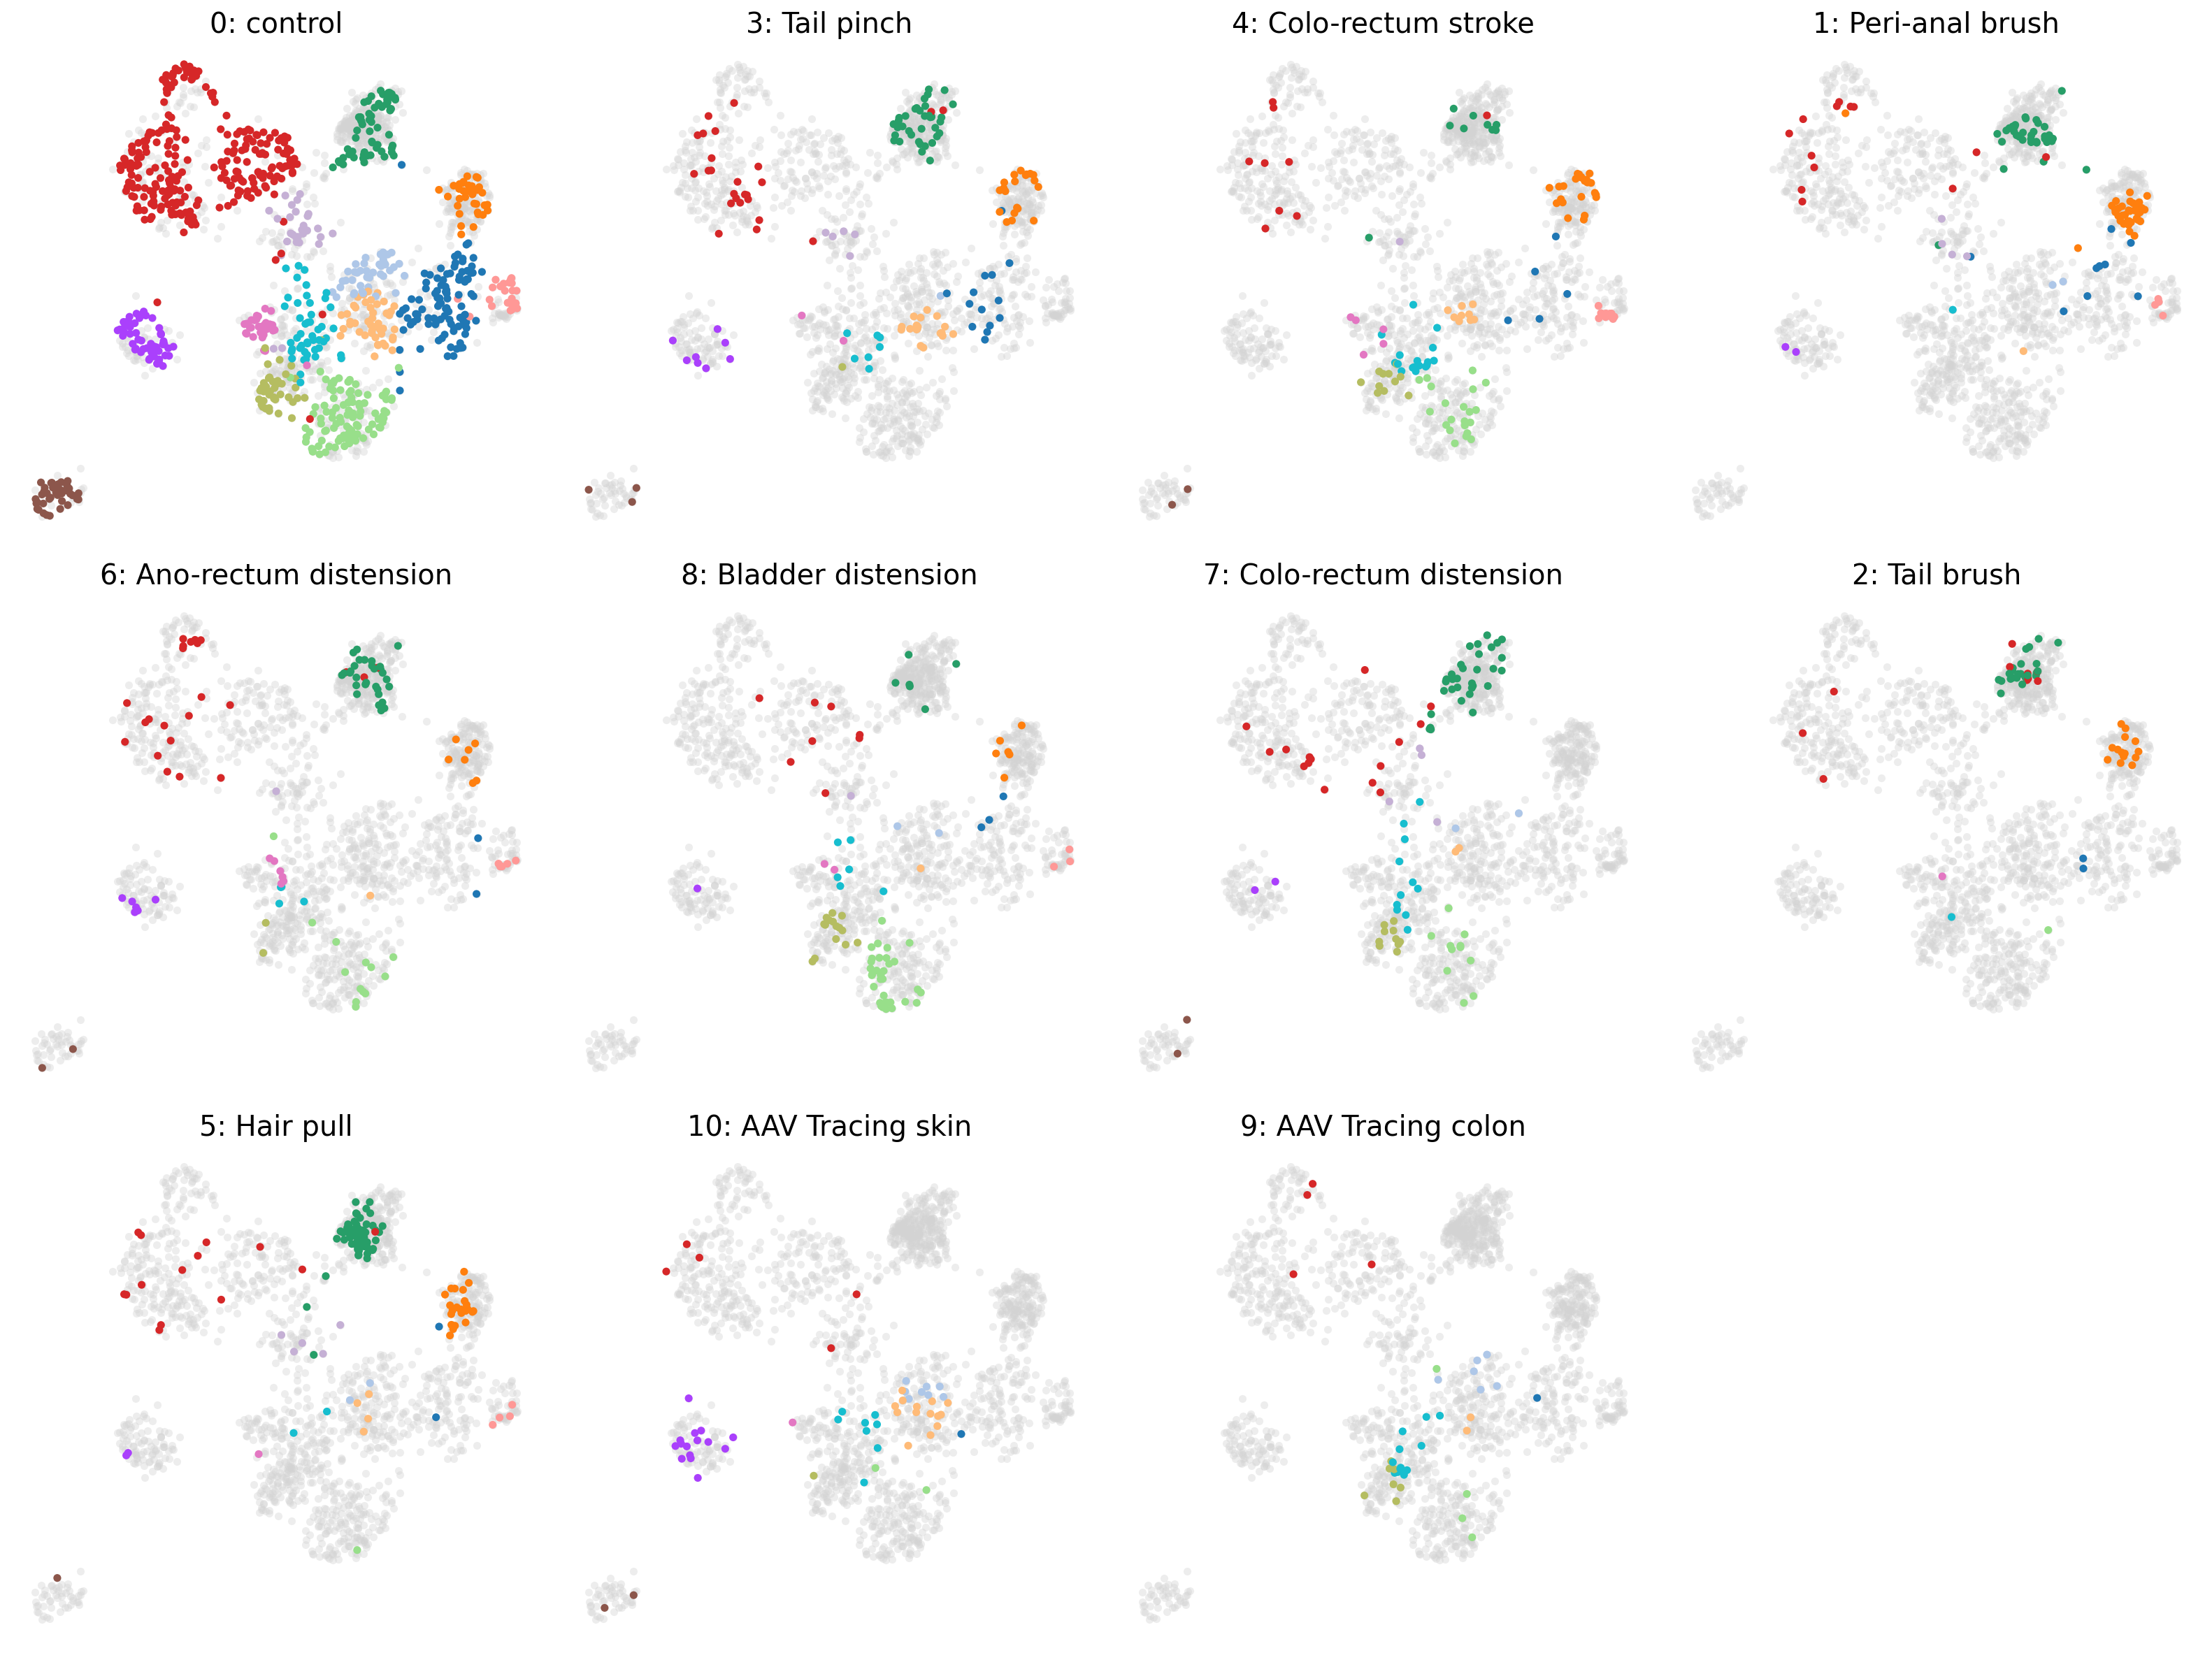

In [24]:

# Get cluster colors (keep same color scheme)
cluster_colors = adata_concat.uns.get('named_louvain_r3_colors', None)

# Extract relevant info
umap = adata_concat.obsm['X_umap']
df = adata_concat.obs.copy()

# Unique stimuli sorted
stimuli = sorted(df['stimulus'].unique())

# Subplot grid layout
n_stim = len(stimuli)
n_cols = int(np.ceil(np.sqrt(n_stim)))
n_rows = int(np.ceil(n_stim / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))
axes = axes.flatten()

# Map cluster name to color (for fast lookup)
if cluster_colors is not None and 'named_louvain_r3' in df.columns:
    cluster_palette = dict(zip(df['named_louvain_r3'].cat.categories, cluster_colors))
else:
    cluster_palette = None

# Plot each stimulus
for i, stim in enumerate(stimuli):
    ax = axes[i]

    # Mask for this stimulus
    mask = df['stimulus'] == stim

    # Plot all cells as gray background
    ax.scatter(
        umap[:, 0],
        umap[:, 1],
        s=25,
        c='lightgray',
        alpha=0.4,
        linewidths=0
    )

    # Overlay colored stimulus cells
    subset = df[mask]
    subset_umap = umap[mask]

    if cluster_palette is not None:
        colors = subset['named_louvain_r3'].map(cluster_palette)
    else:
        colors = 'blue'  # fallback

    ax.scatter(
        subset_umap[:, 0],
        subset_umap[:, 1],
        s=25,
        c=colors,
        linewidths=0
    )

    ax.set_title(stimuli4title.get(stim, f"Stimulus {stim}"), fontsize=18)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_frame_on(False)

# Hide unused axes (if grid bigger than stimuli count)
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


# Export

In [ ]:
# for integration
adata_concat.write_h5ad(
    os.path.join(input_path , 'campari_scs_umap_cells_'+condition + '_'+str(HIGHLY_VARIABLE_GENES)+'_embedding_filtered_PCs_'+str(N_selected)+'_MergedCluster.h5ad'),
)

# Rank genes Atlas

In [26]:
adata_all_norm_control.obs['merged_' + clustering_method] = adata_control.obs['merged_' + clustering_method]
sc.tl.rank_genes_groups(adata_all_norm_control, 'merged_' + clustering_method, method='wilcoxon')
rank_genes_df = pd.DataFrame(adata_all_norm_control.uns['rank_genes_groups']['names']).head(100)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)


         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:02)
Storing dendrogram info using `.uns['dendrogram_merged_louvain_r3']`


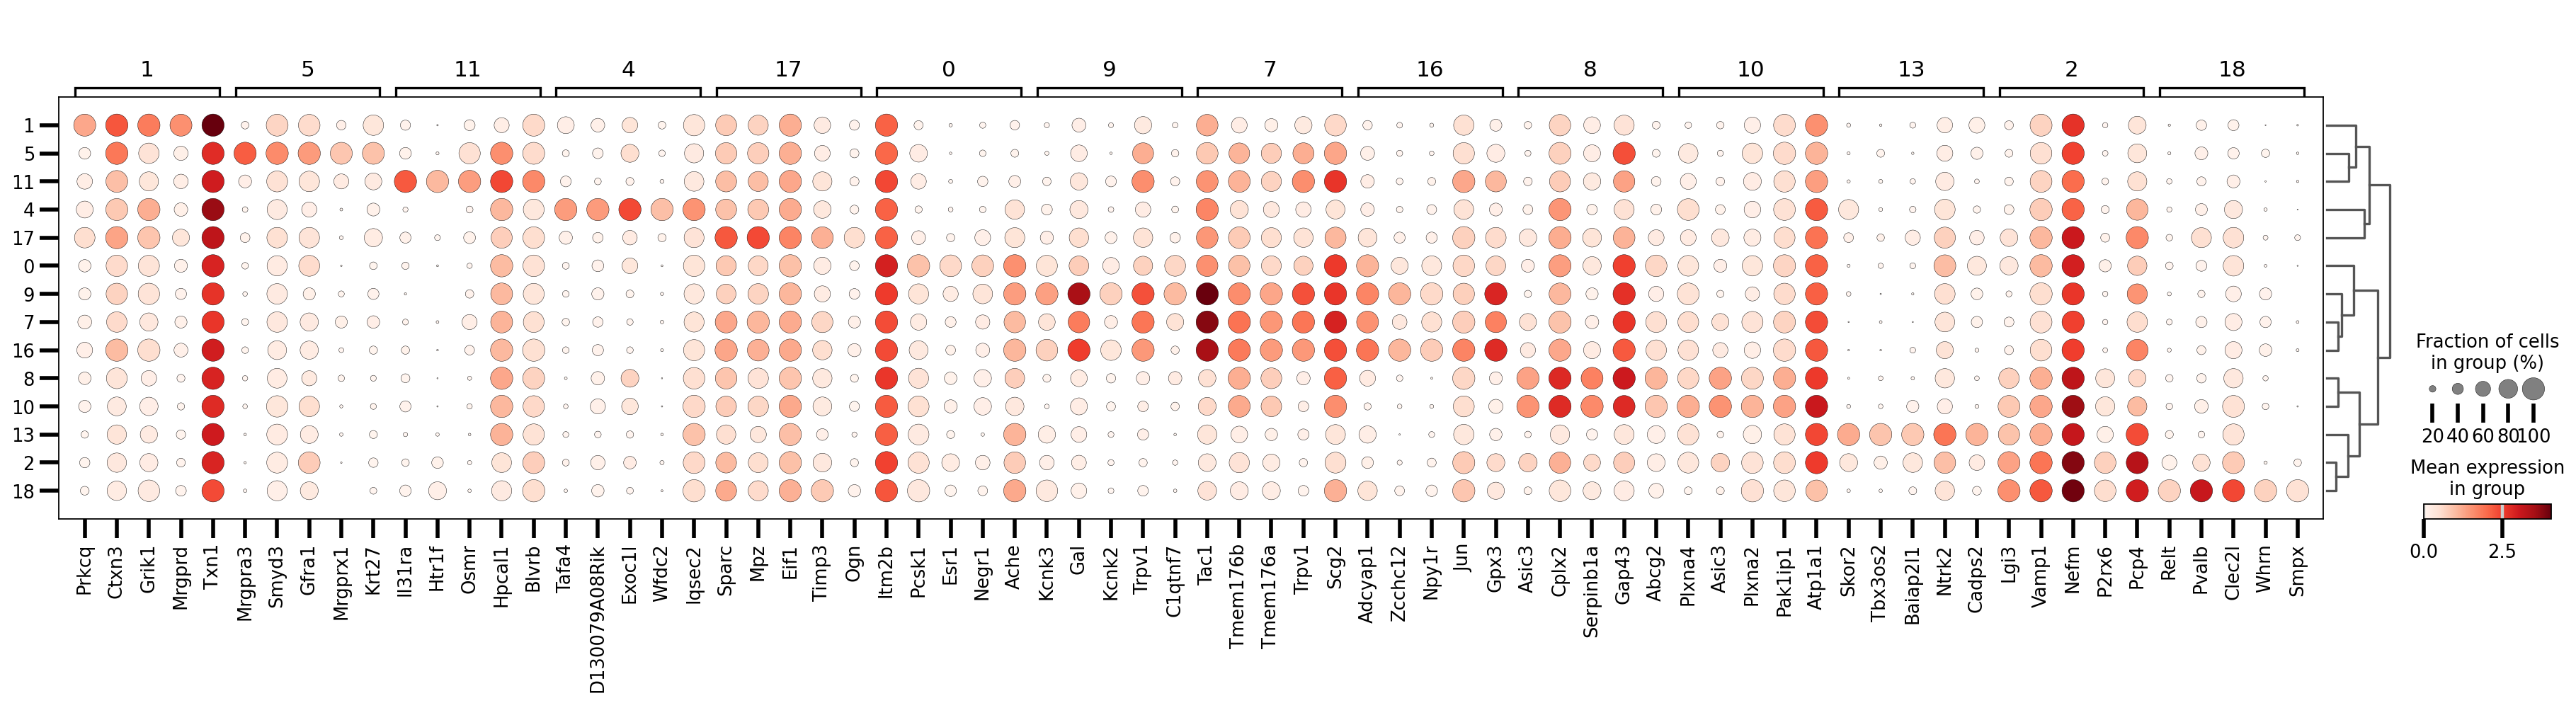

In [27]:
adata_all_norm_control.var_names_make_unique()
sc.pl.rank_genes_groups_dotplot(adata_all_norm_control, n_genes=5)

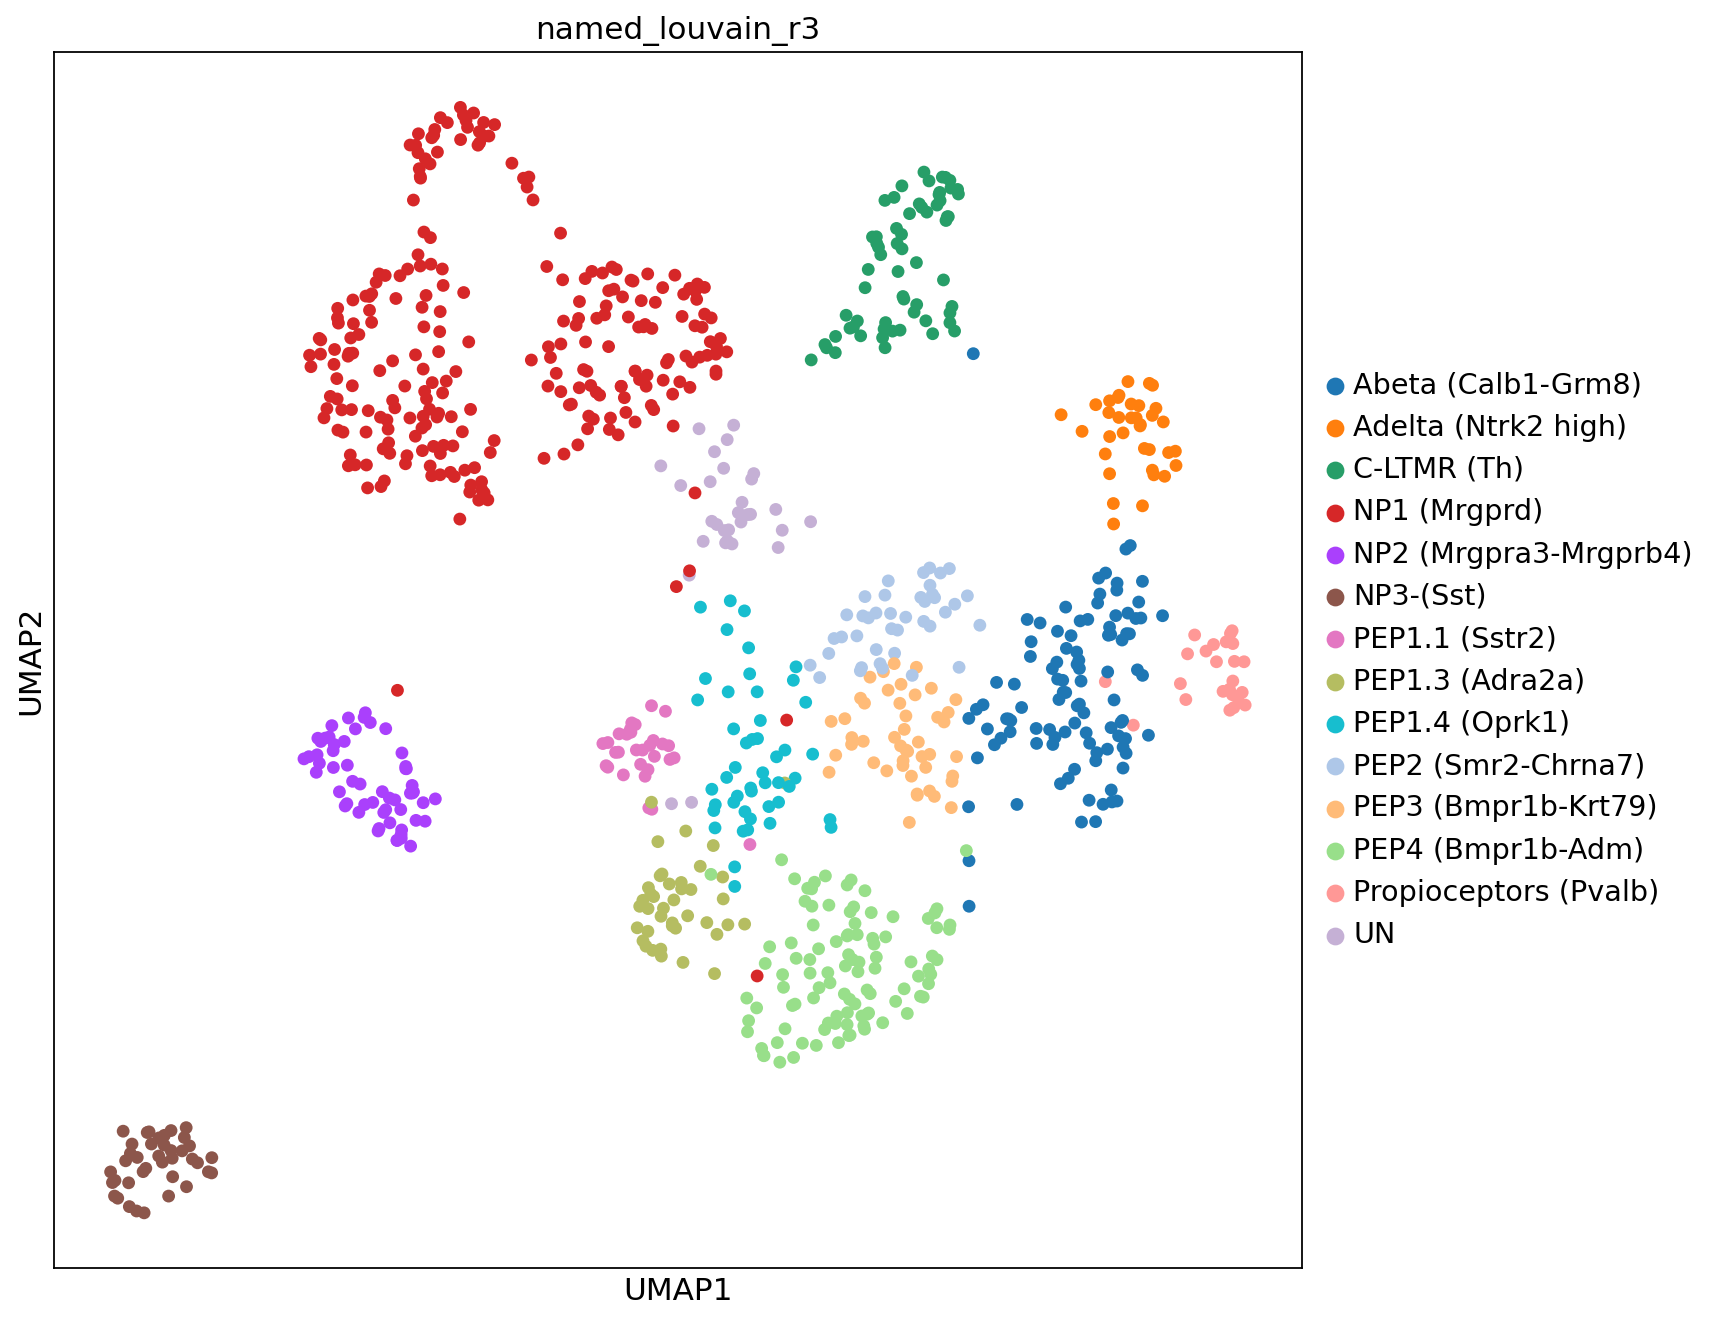

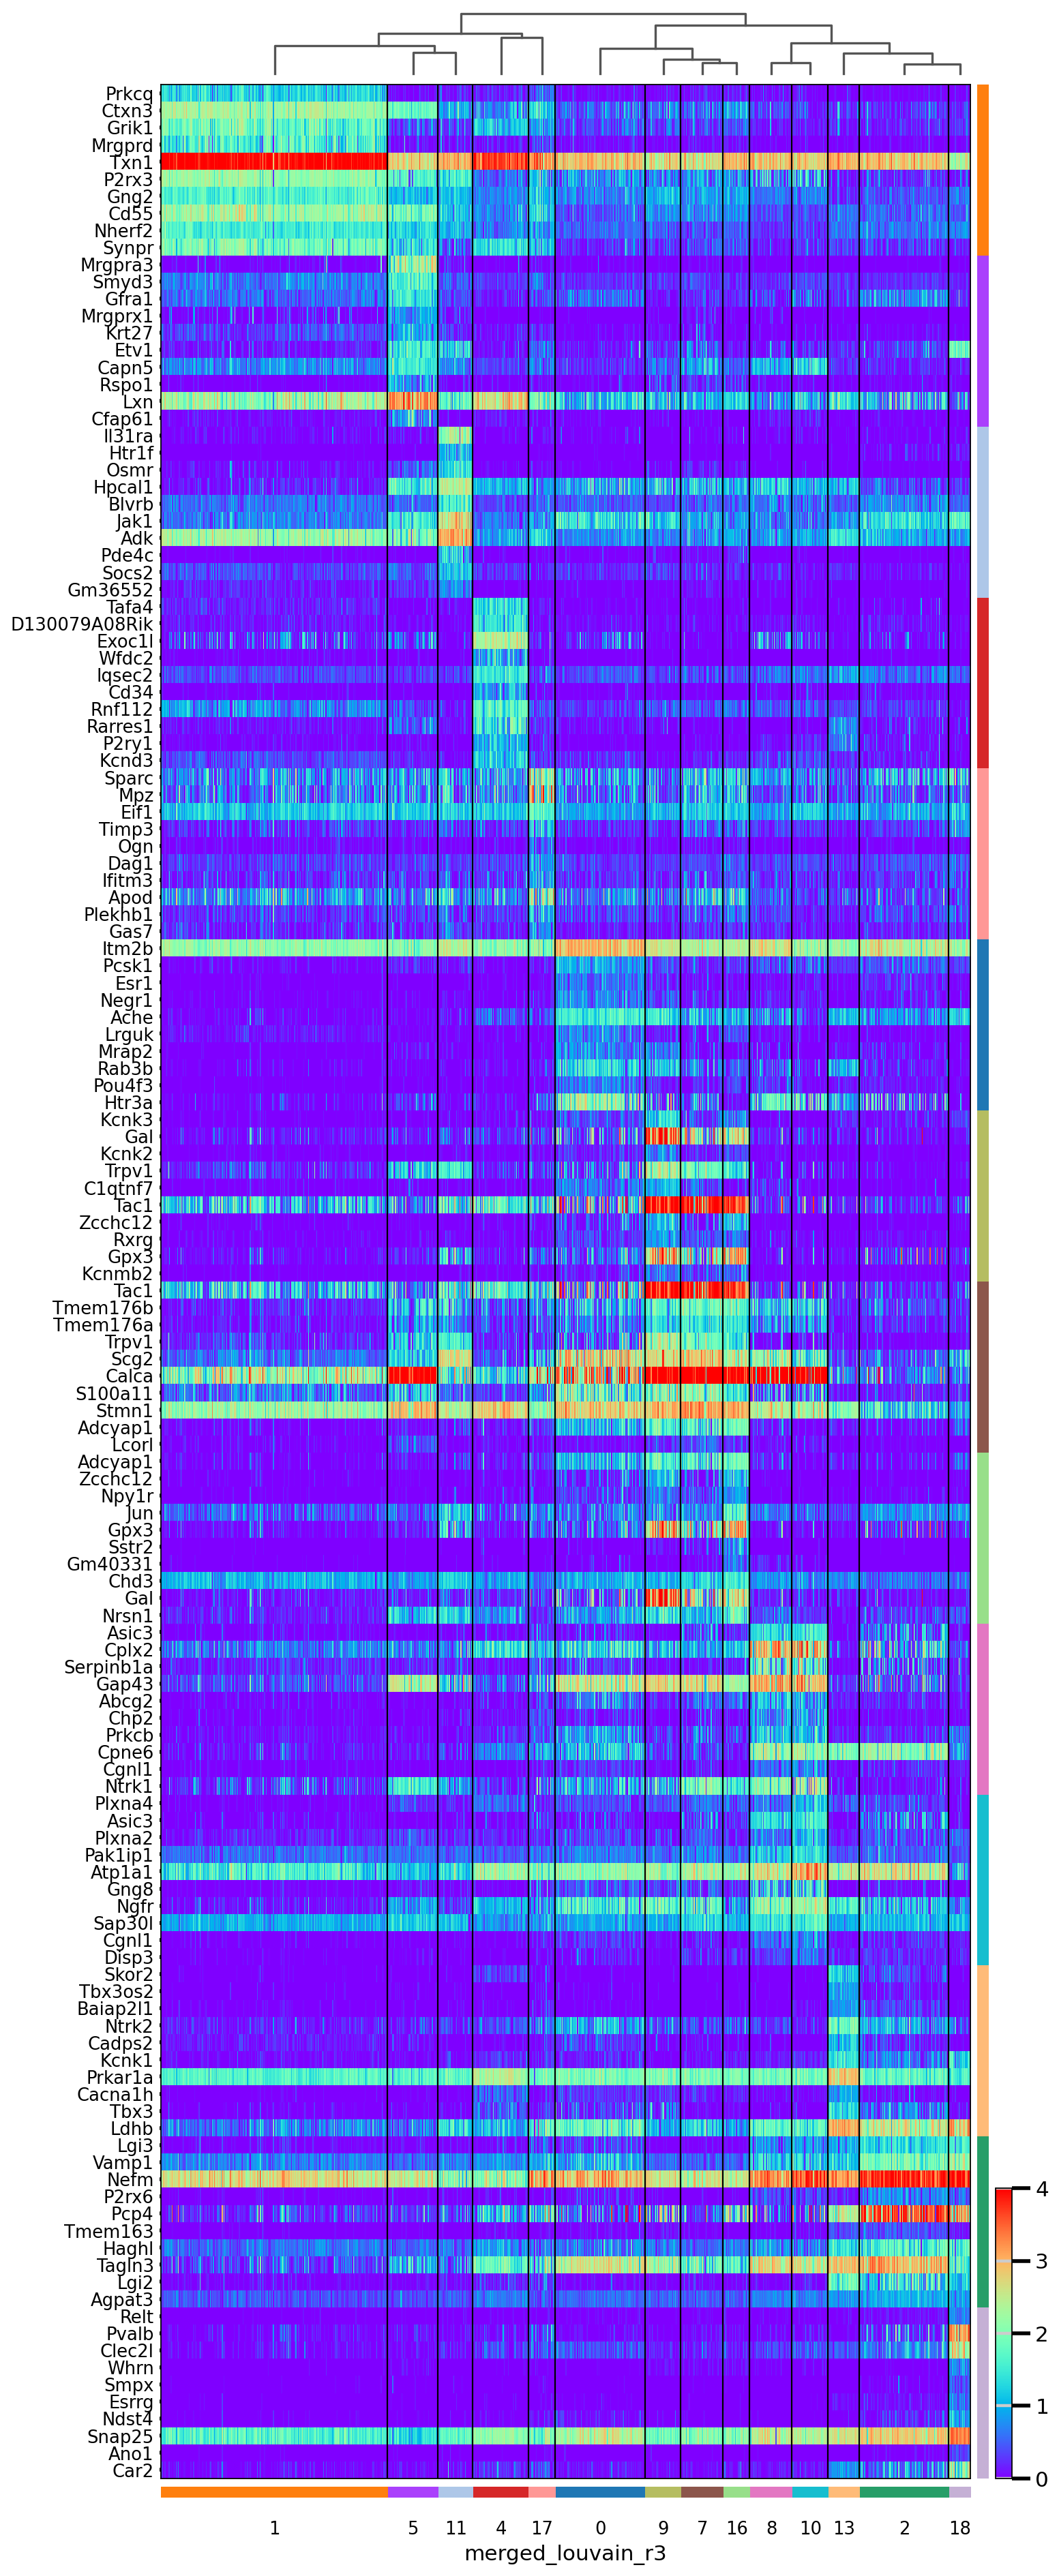

In [28]:
sc.pl.umap(adata_control, color='named_' + clustering_method)
sc.pl.rank_genes_groups_heatmap(adata_all_norm_control, n_genes=10, use_raw=False, show_gene_labels=True,swap_axes=True, vmin=0, vmax=4, cmap='rainbow', figsize=(10,30), show=True, 
                               dendrogram = True)

In [29]:

sc.tl.rank_genes_groups(adata_control, 'merged_' + clustering_method, method='wilcoxon')
rank_genes_df = pd.DataFrame(adata_control.uns['rank_genes_groups']['names']).head(100)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)


    using 'X_pca' with n_pcs = 25
Storing dendrogram info using `.uns['dendrogram_merged_louvain_r3']`


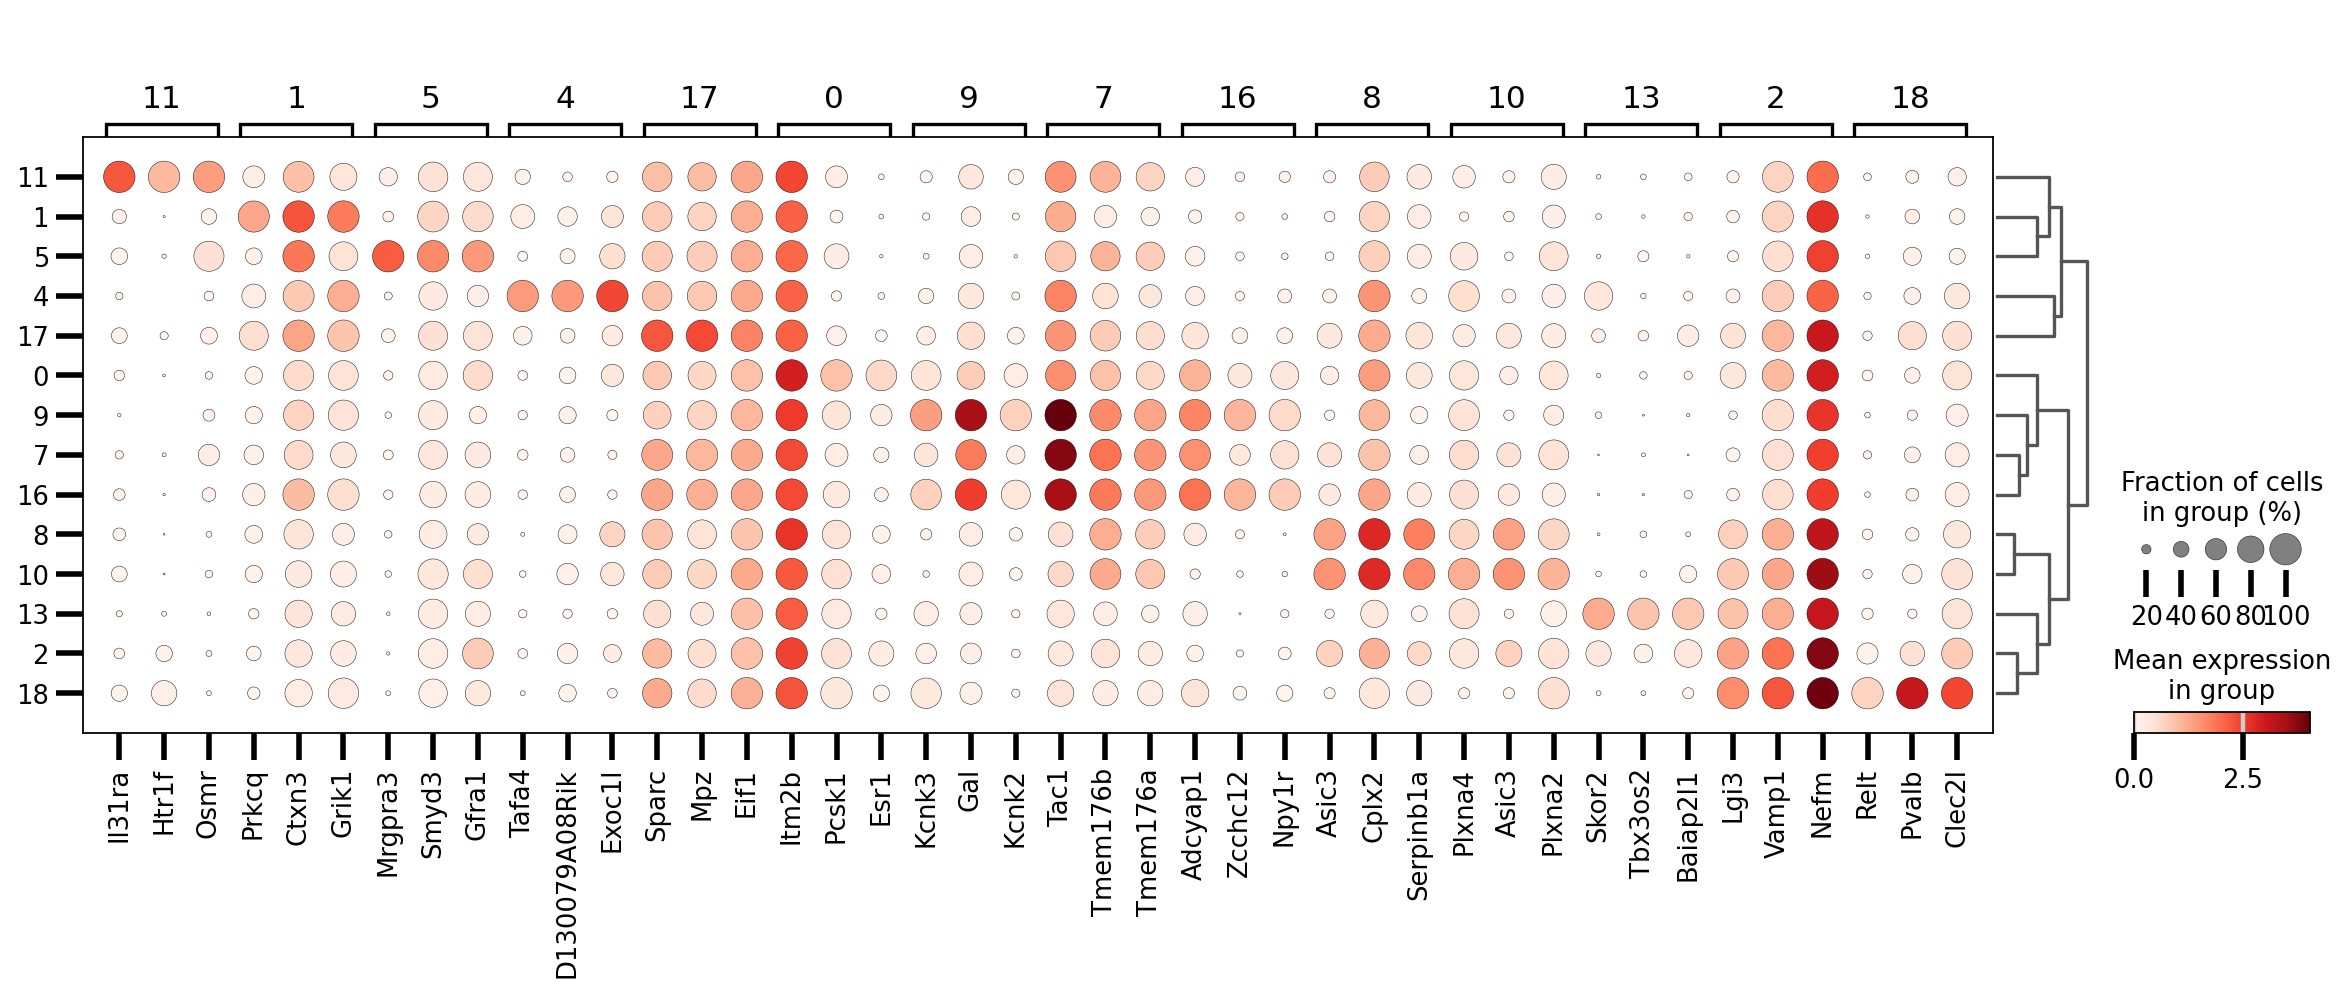

In [30]:
adata_control.var_names_make_unique()
sc.pl.rank_genes_groups_dotplot(adata_control, n_genes=3)

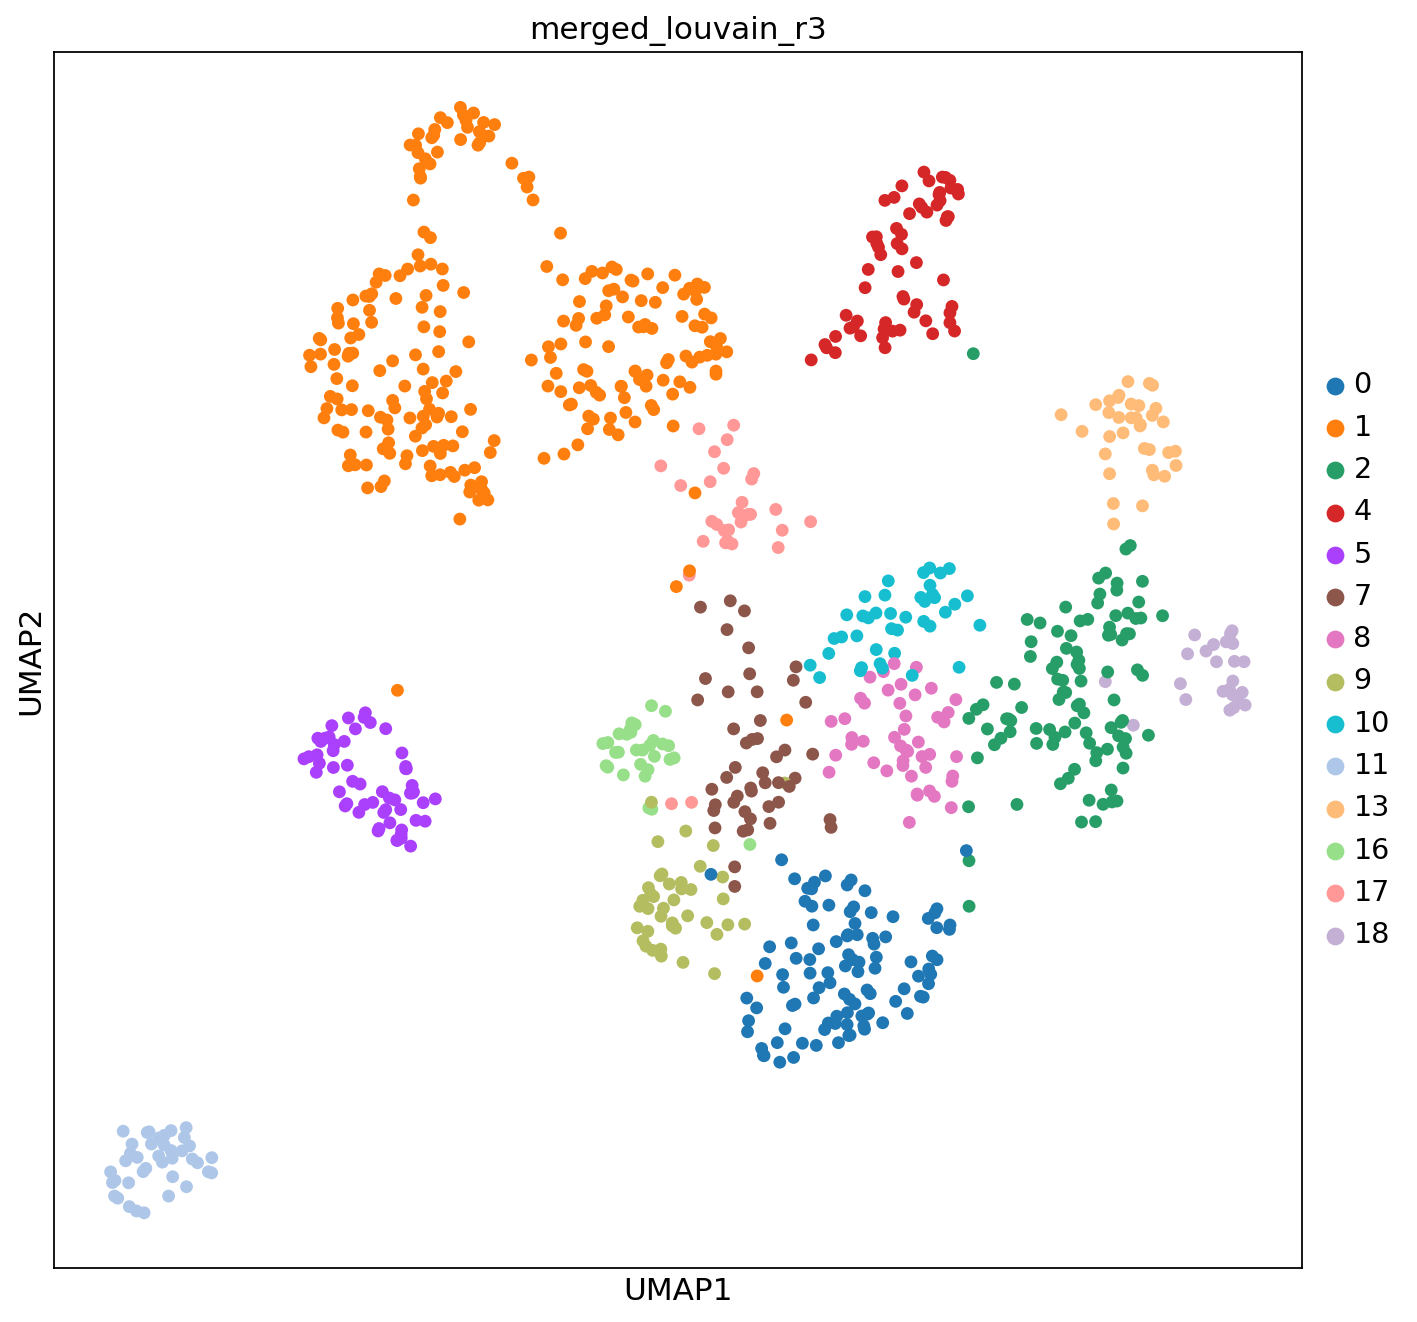

In [31]:
sc.pl.umap(adata_control, color='merged_' + clustering_method)